In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator 
from yellowbrick.cluster import silhouette_visualizer 
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

from decimal import Decimal

In [3]:
data = pd.read_csv('../data/bike_clean.csv')

In [4]:
data.head()

,Unnamed: 0,datetime,date,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,1,2017-12-01 00:00:00,2017-12-01,0,Winter,No Holiday,Yes,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,2,2017-12-01 01:00:00,2017-12-01,1,Winter,No Holiday,Yes,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,3,2017-12-01 02:00:00,2017-12-01,2,Winter,No Holiday,Yes,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,4,2017-12-01 03:00:00,2017-12-01,3,Winter,No Holiday,Yes,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,5,2017-12-01 04:00:00,2017-12-01,4,Winter,No Holiday,Yes,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


## K means clustering
### Scaling Data

In [5]:
df_kmean = data.drop(columns = ['Unnamed: 0', 'season', 'holiday','open', 'datetime', 'date'])

In [6]:
dataarray = df_kmean.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 
scaled_features

array([[-1.66132477, -0.69865046, -1.51395724, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [-1.51686175, -0.77617457, -1.53907415, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [-1.37239873, -0.82423951, -1.58093567, ..., -0.65513172,
        -0.13179988, -0.17189109],
       ...,
       [ 1.37239873, -0.0164383 , -0.86091752, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [ 1.51686175,  0.01147038, -0.90277904, ..., -0.65513172,
        -0.13179988, -0.17189109],
       [ 1.66132477, -0.18699134, -0.91952365, ..., -0.65513172,
        -0.13179988, -0.17189109]])

### Evaluating WCSS

In [7]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

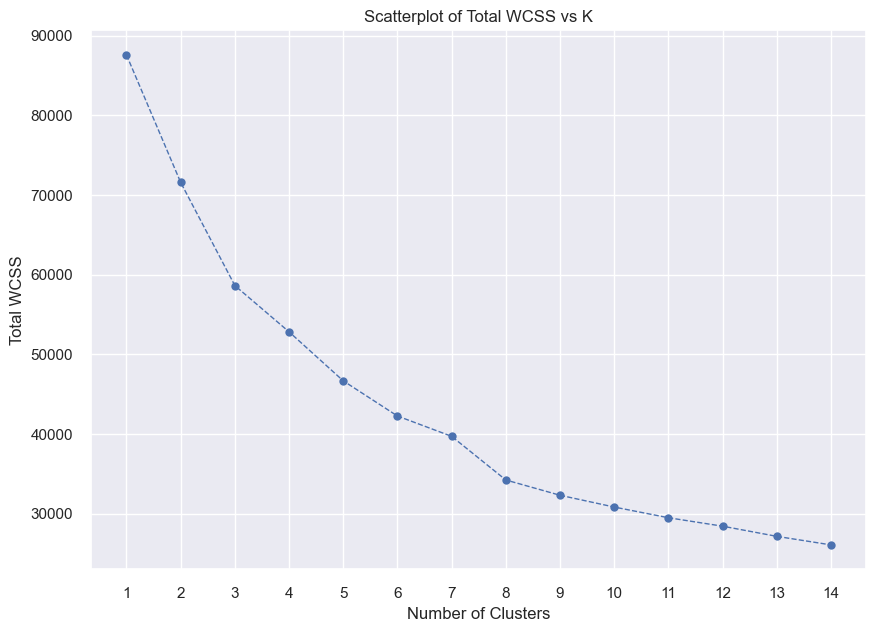

In [8]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [9]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

8

In [10]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

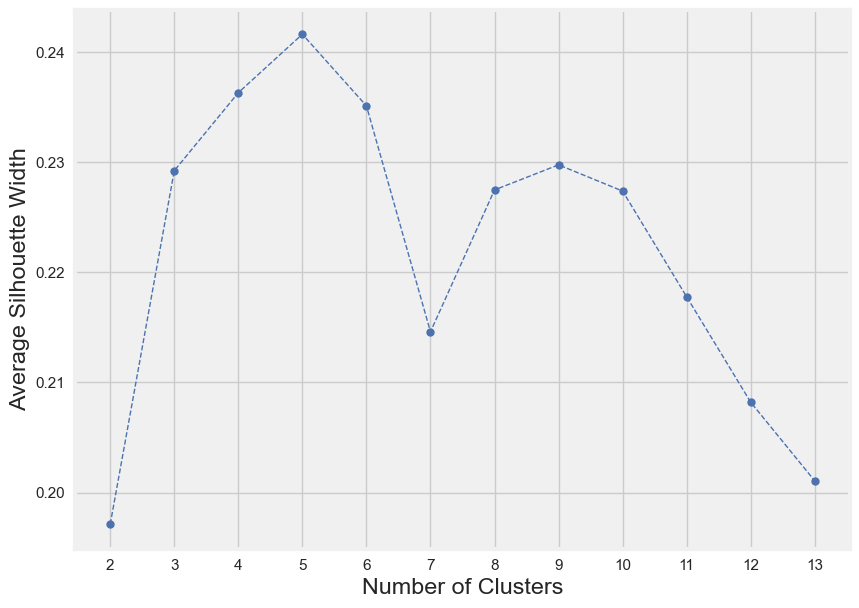

In [11]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [53]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

### Kmeans with 3 clusters

In [77]:
kmeans3 = KMeans(init="random",n_clusters =3 , random_state = 42)
kmeans3.fit(scaled_features)
clustergroups3 = kmeans3.labels_
Clustercenters3 = pd.DataFrame(kmeans3.cluster_centers_)
Clustercenters3

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups3)}')

CH score: 2162.5346475800516


In [28]:
model3 = kmeans_label(df_kmean, 3)
model3.head()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,Clusters
0,0,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,2
1,1,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,2
2,2,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,2
3,3,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,2
4,4,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,2


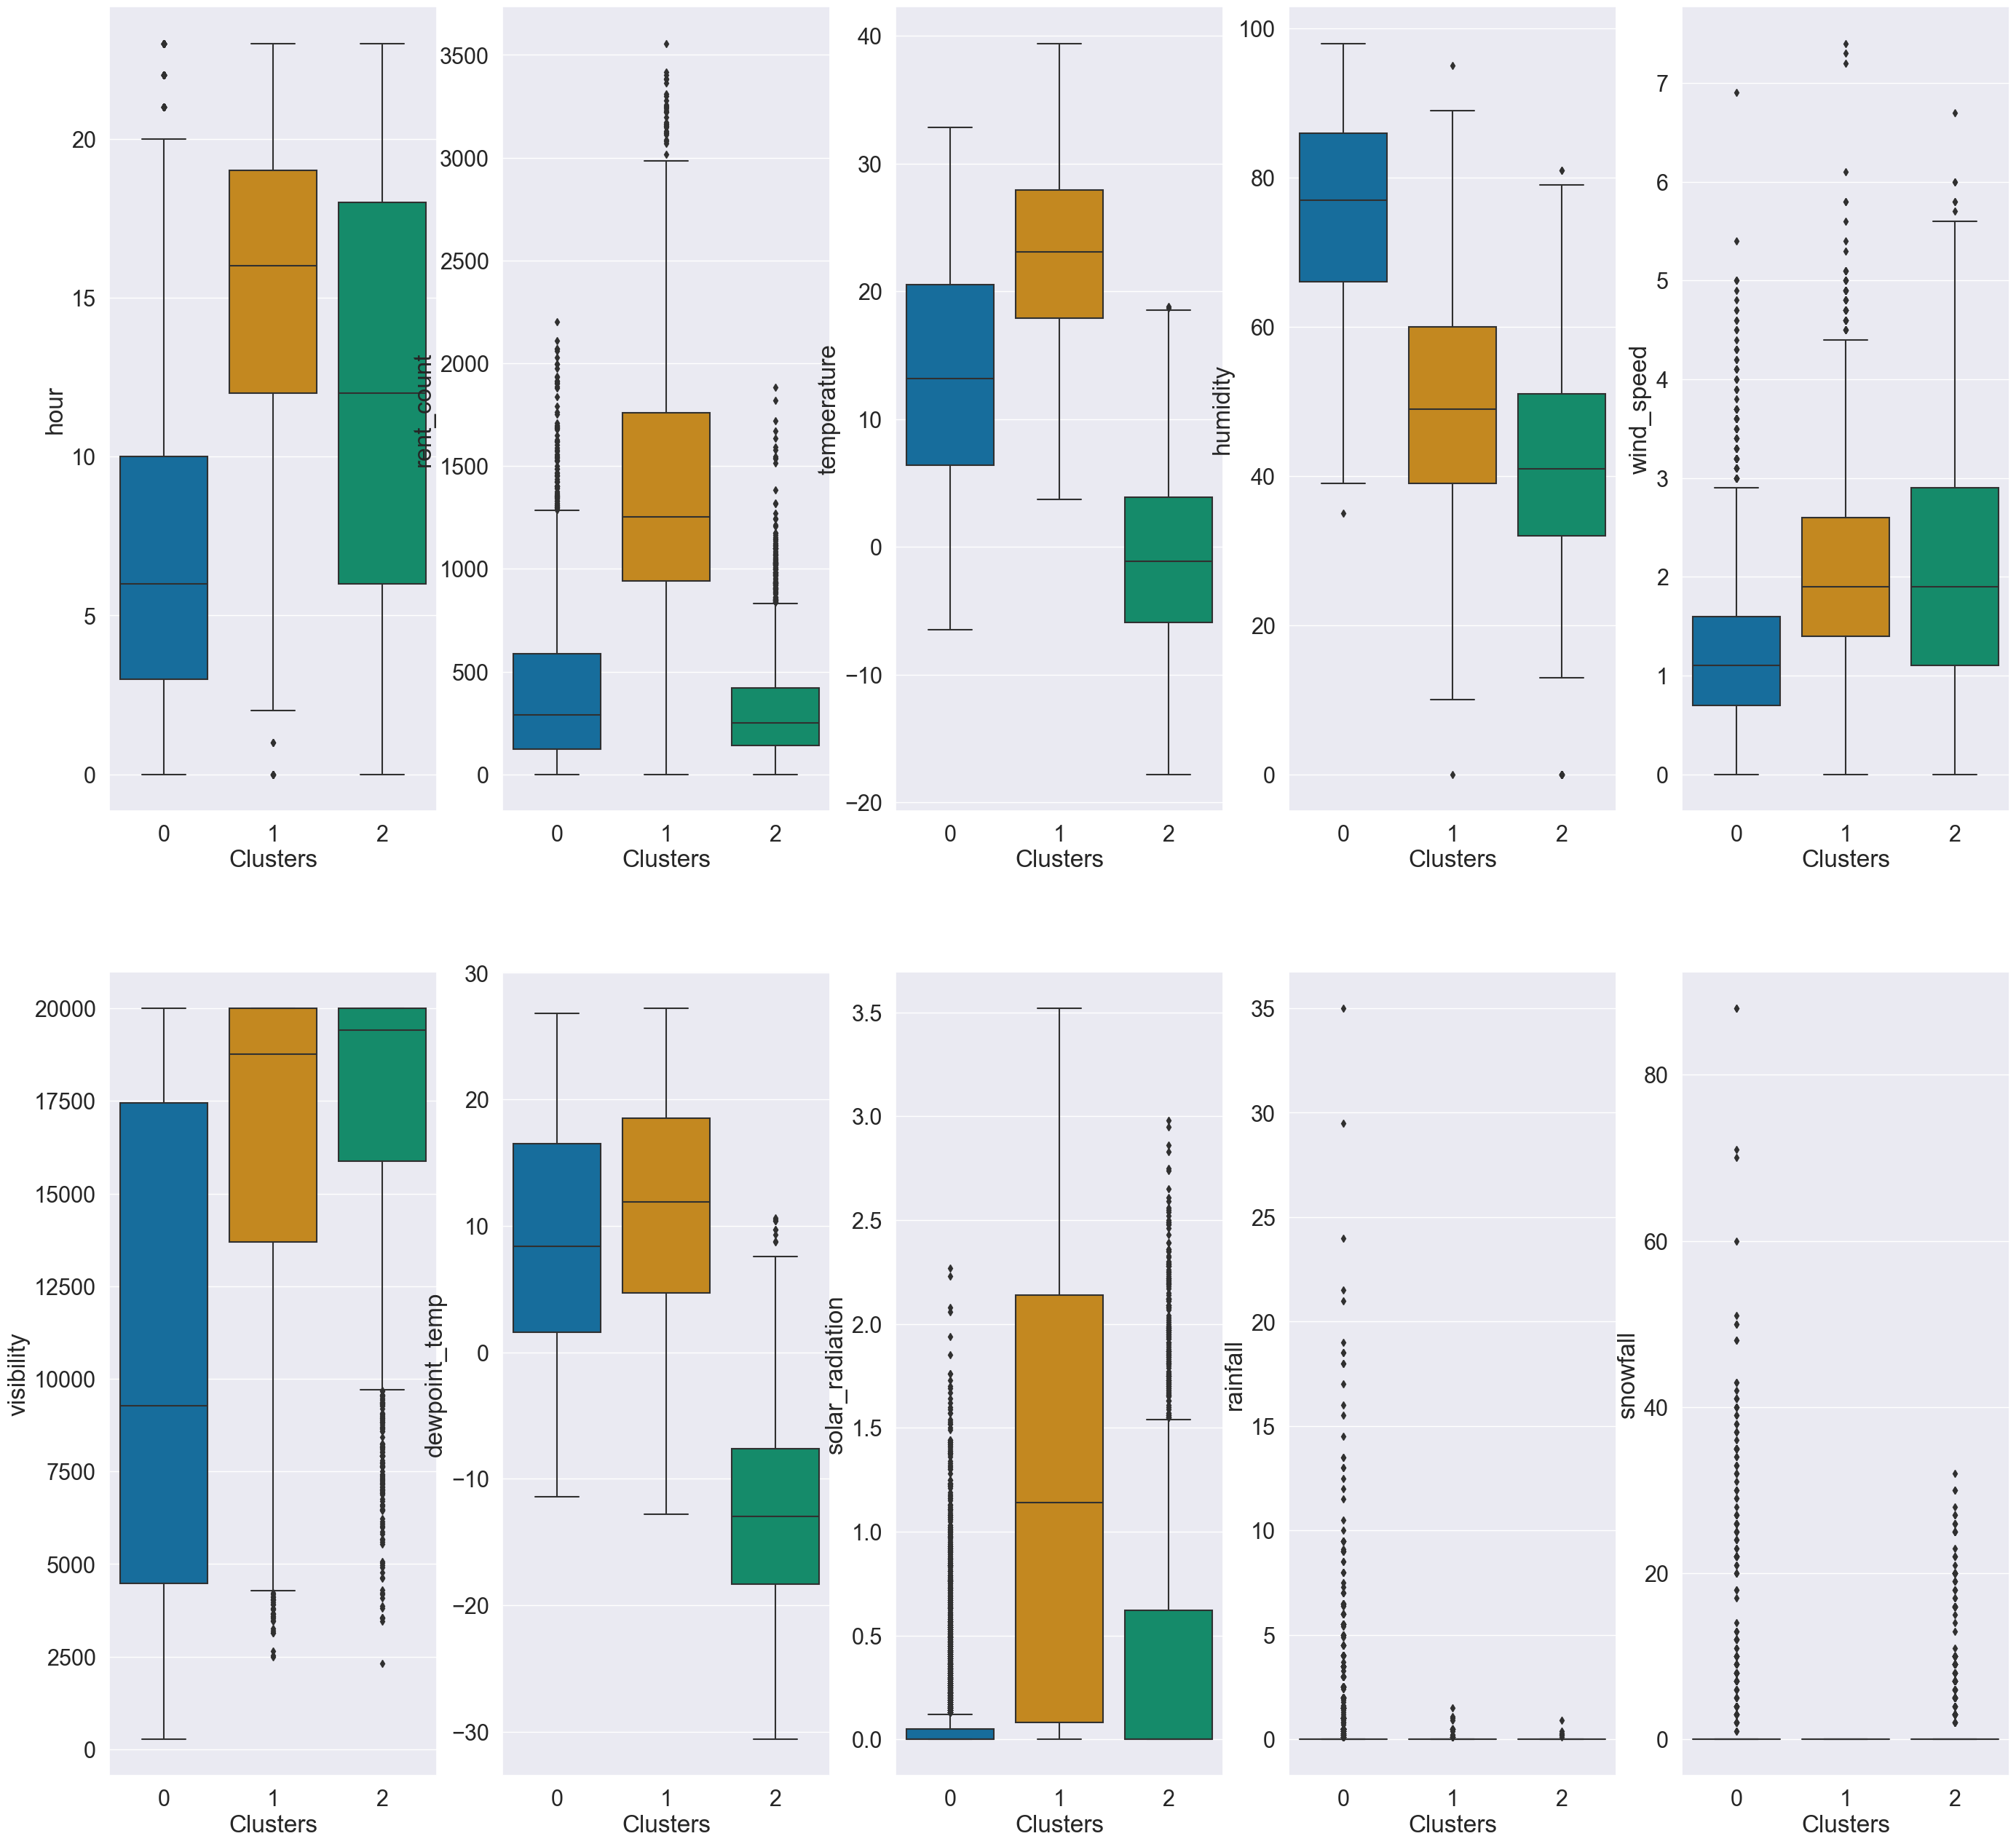

In [50]:
plot_boxplots(model3)
plt.show()

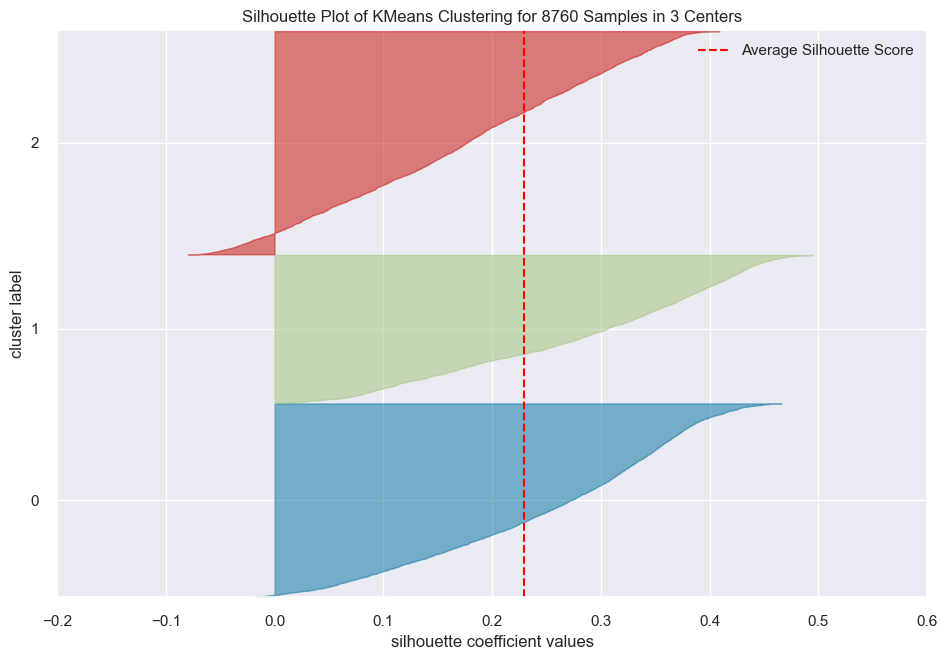

For n_clusters = 3 The average silhouette_score is: 0.22923396348047517 


In [52]:
plot_silhouettes(df_kmean,3)
plt.show()

### Kmeans with 4 clusters

In [78]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(scaled_features)
clustergroups4 = kmeans4.labels_
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_)
Clustercenters4

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups4)}')

CH score: 1920.84756747687


In [55]:
model4 = kmeans_label(df_kmean, 4)
model4.head()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,Clusters
0,0,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,2
1,1,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,2
2,2,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,2
3,3,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,2
4,4,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,2


In [81]:
model4.Clusters.value_counts()

1    3434
0    2979
2    2281
3      66
Name: Clusters, dtype: int64

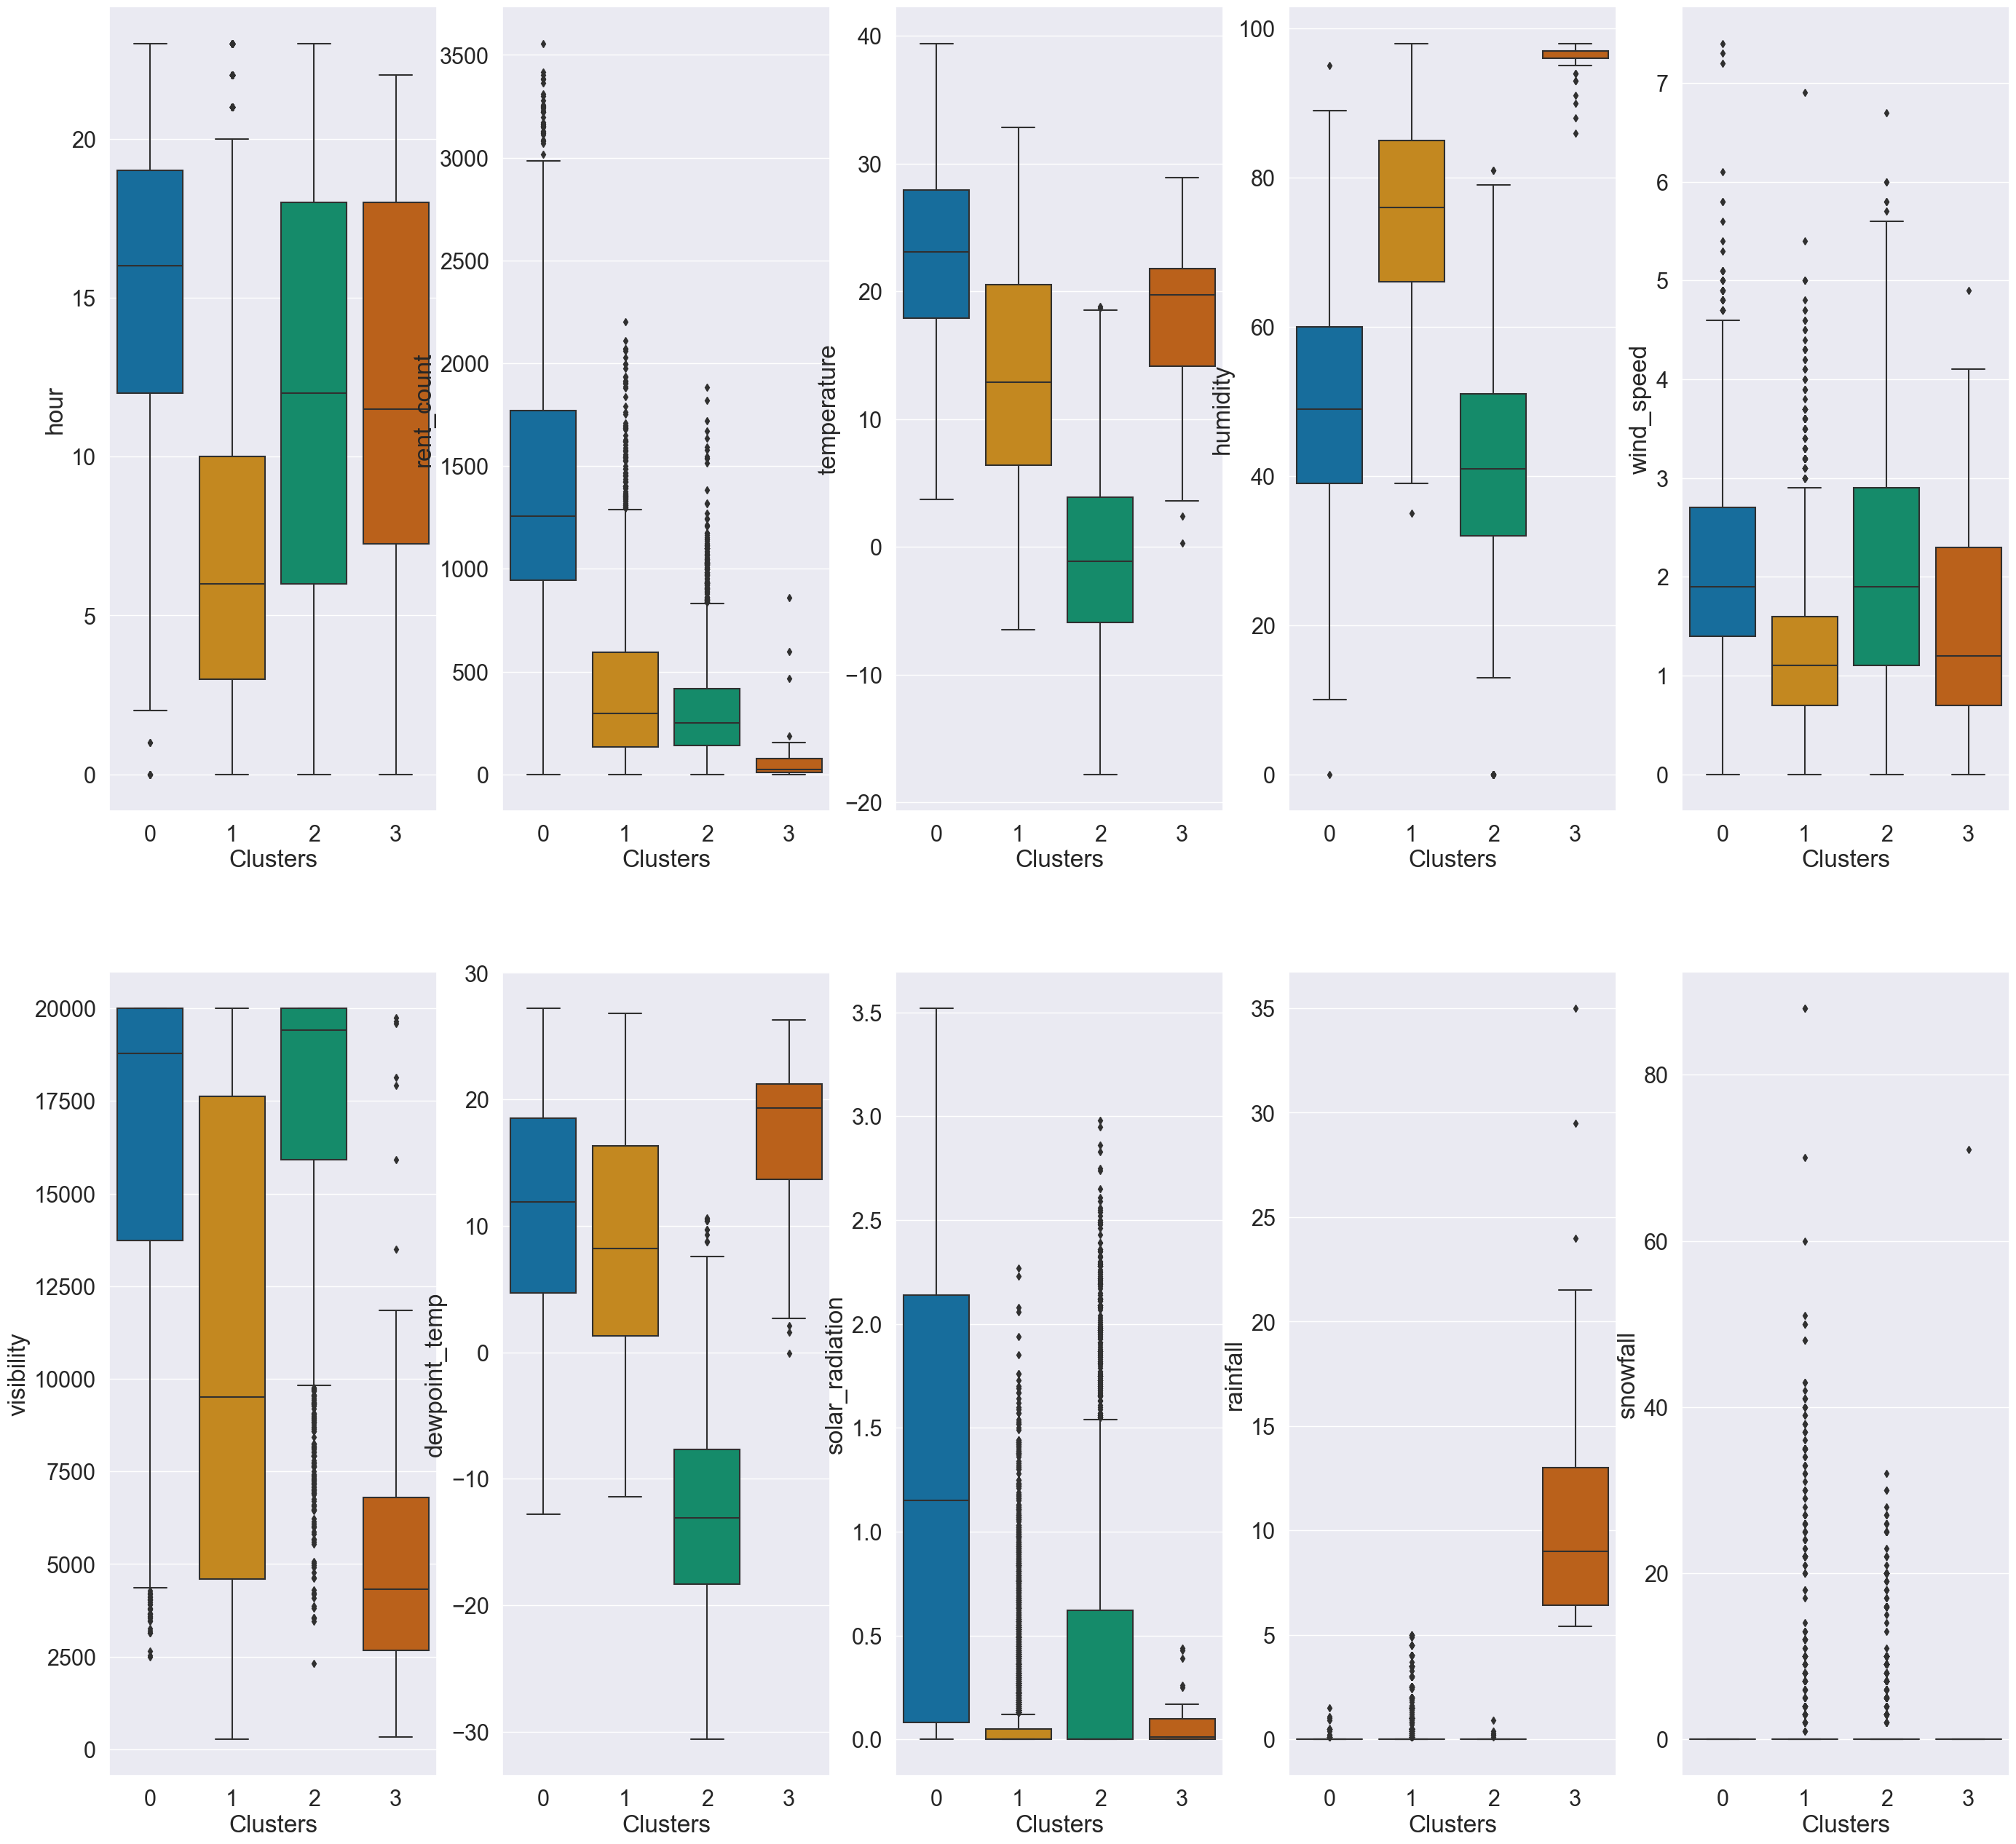

In [56]:
plot_boxplots(model4)
plt.show()

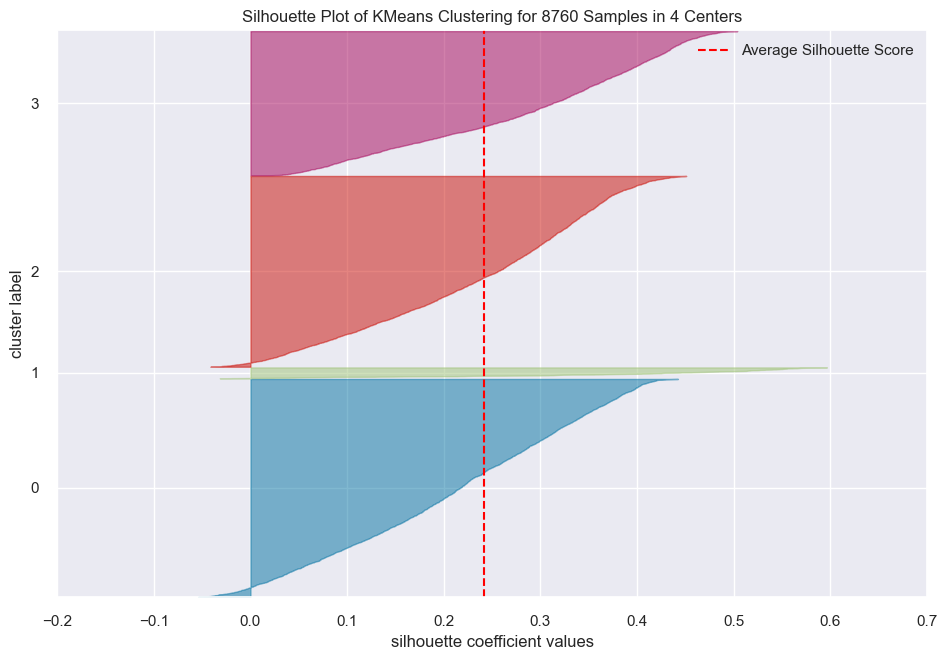

For n_clusters = 4 The average silhouette_score is: 0.24197827933813065 


In [57]:
plot_silhouettes(df_kmean,4)
plt.show()

### Kmeans with 5 clusters

In [79]:
kmeans5 = KMeans(init="random",n_clusters =5 , random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_)
Clustercenters5

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')

CH score: 1918.7922788669516


In [83]:
model5 = kmeans_label(df_kmean, 5)
model5.head()
model5.Clusters.value_counts()

4    3239
0    2167
3    1628
2    1558
1     168
Name: Clusters, dtype: int64

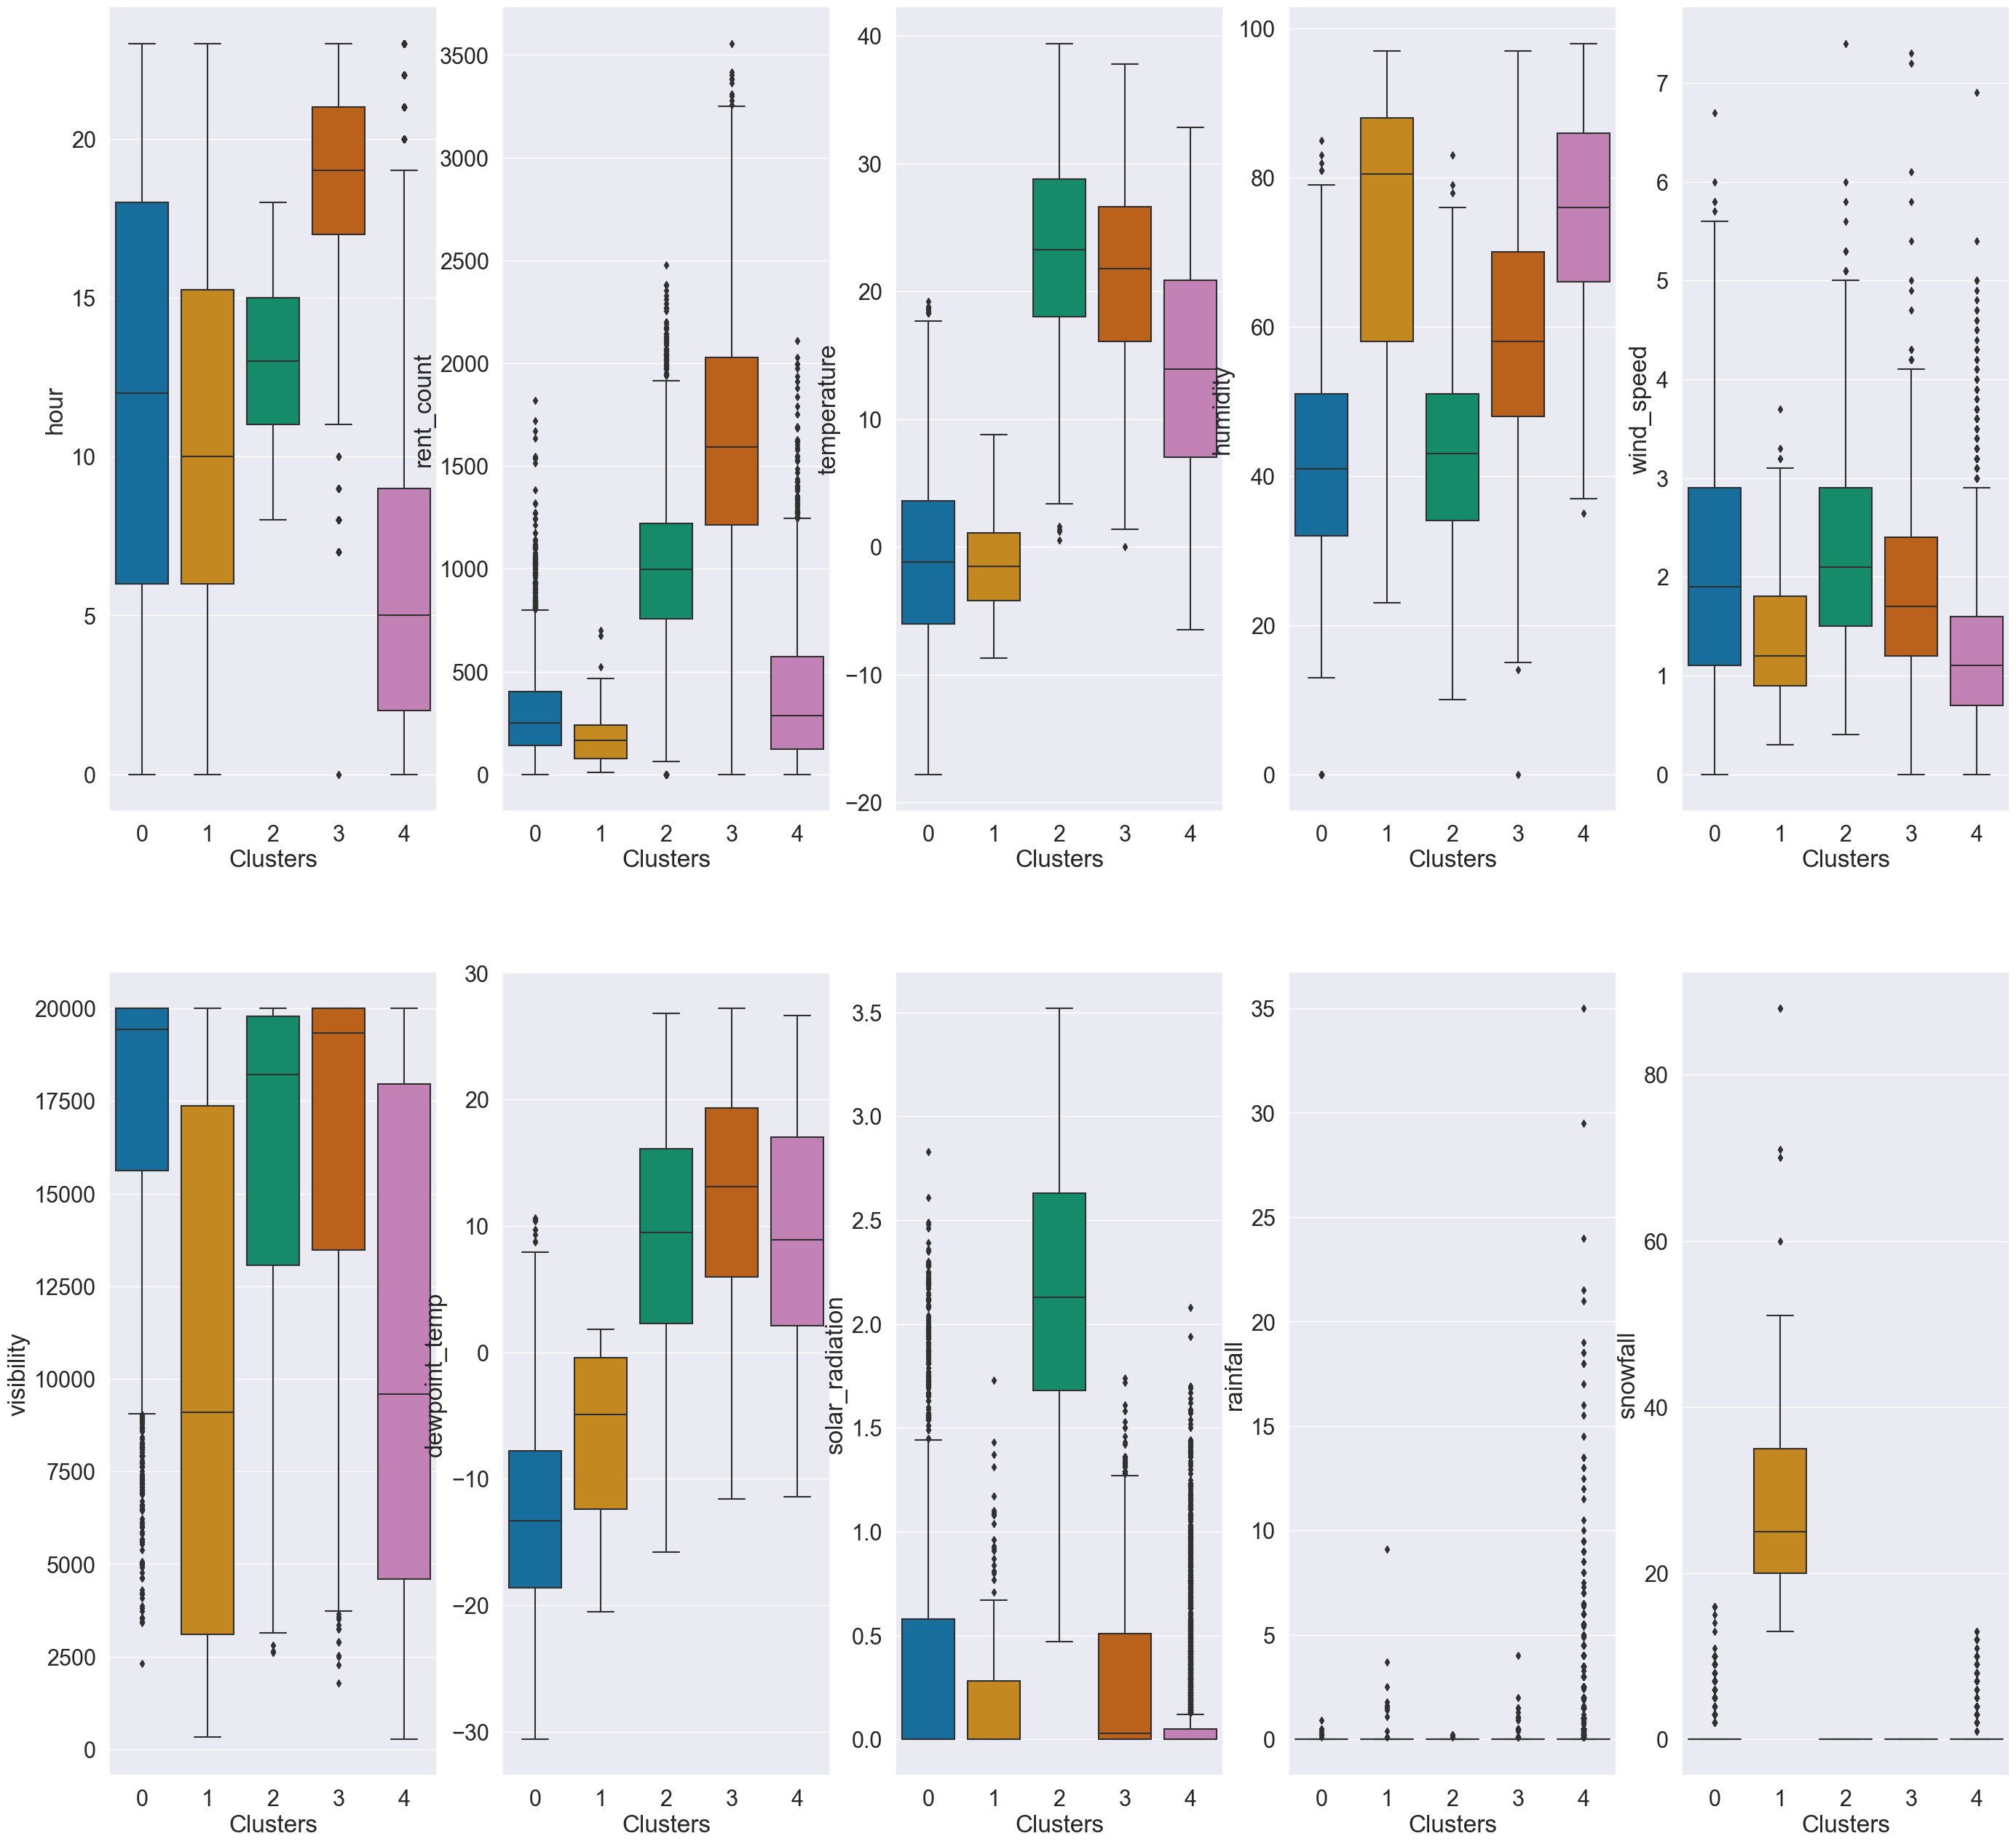

In [60]:
plot_boxplots(model5)
plt.show()

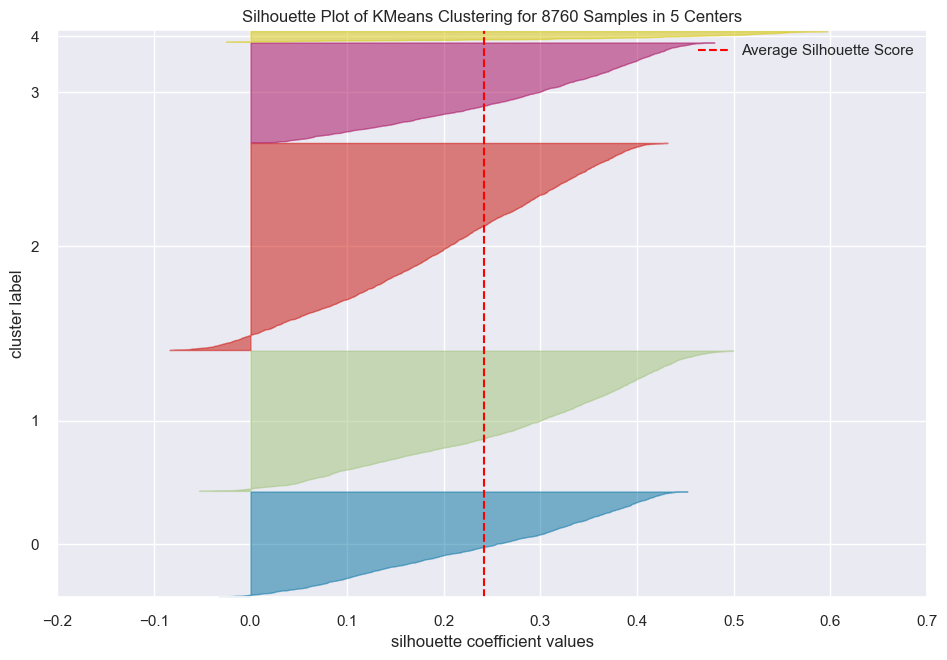

For n_clusters = 5 The average silhouette_score is: 0.24147238601129223 


In [61]:
plot_silhouettes(df_kmean,5)
plt.show()

### Kmeans with 6 clusters

In [62]:
kmeans6 = KMeans(init="random",n_clusters =6 , random_state = 42)
kmeans6.fit(scaled_features)
clustergroups6 = kmeans6.labels_
Clustercenters6 = pd.DataFrame(kmeans6.cluster_centers_)
Clustercenters6

,0,1,2,3,4,5,6,7,8,9
0,0.233345,0.498962,0.860597,-0.767489,0.553651,0.260520,0.391474,1.840979,-0.130929,-0.171891
1,-0.228044,-0.581263,-0.218101,1.069730,-0.334070,-1.471437,0.209450,-0.493454,0.457110,-0.085928
2,-0.969189,-0.360610,0.395081,0.531456,-0.608066,0.405793,0.580232,-0.503386,-0.095473,-0.168624
3,0.092889,-0.607281,-1.216330,-0.859476,0.362020,0.534745,-1.367338,-0.239483,-0.130758,-0.039012
4,1.058572,1.529493,0.714788,-0.016284,0.083339,0.363915,0.628179,-0.329752,-0.120861,-0.171891
5,-0.120096,-0.811593,-1.202770,0.686232,-0.290873,-0.730185,-0.795772,-0.416996,-0.000972,6.307111


In [64]:
model6 = kmeans_label(df_kmean, 6)
model6.head()

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,Clusters
0,0,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,3
1,1,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,3
2,2,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,3
3,3,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,3
4,4,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,3


In [96]:
model6.Clusters.value_counts(dropna=False)

3    2041
1    1781
2    1753
0    1527
4    1492
5     166
Name: Clusters, dtype: int64

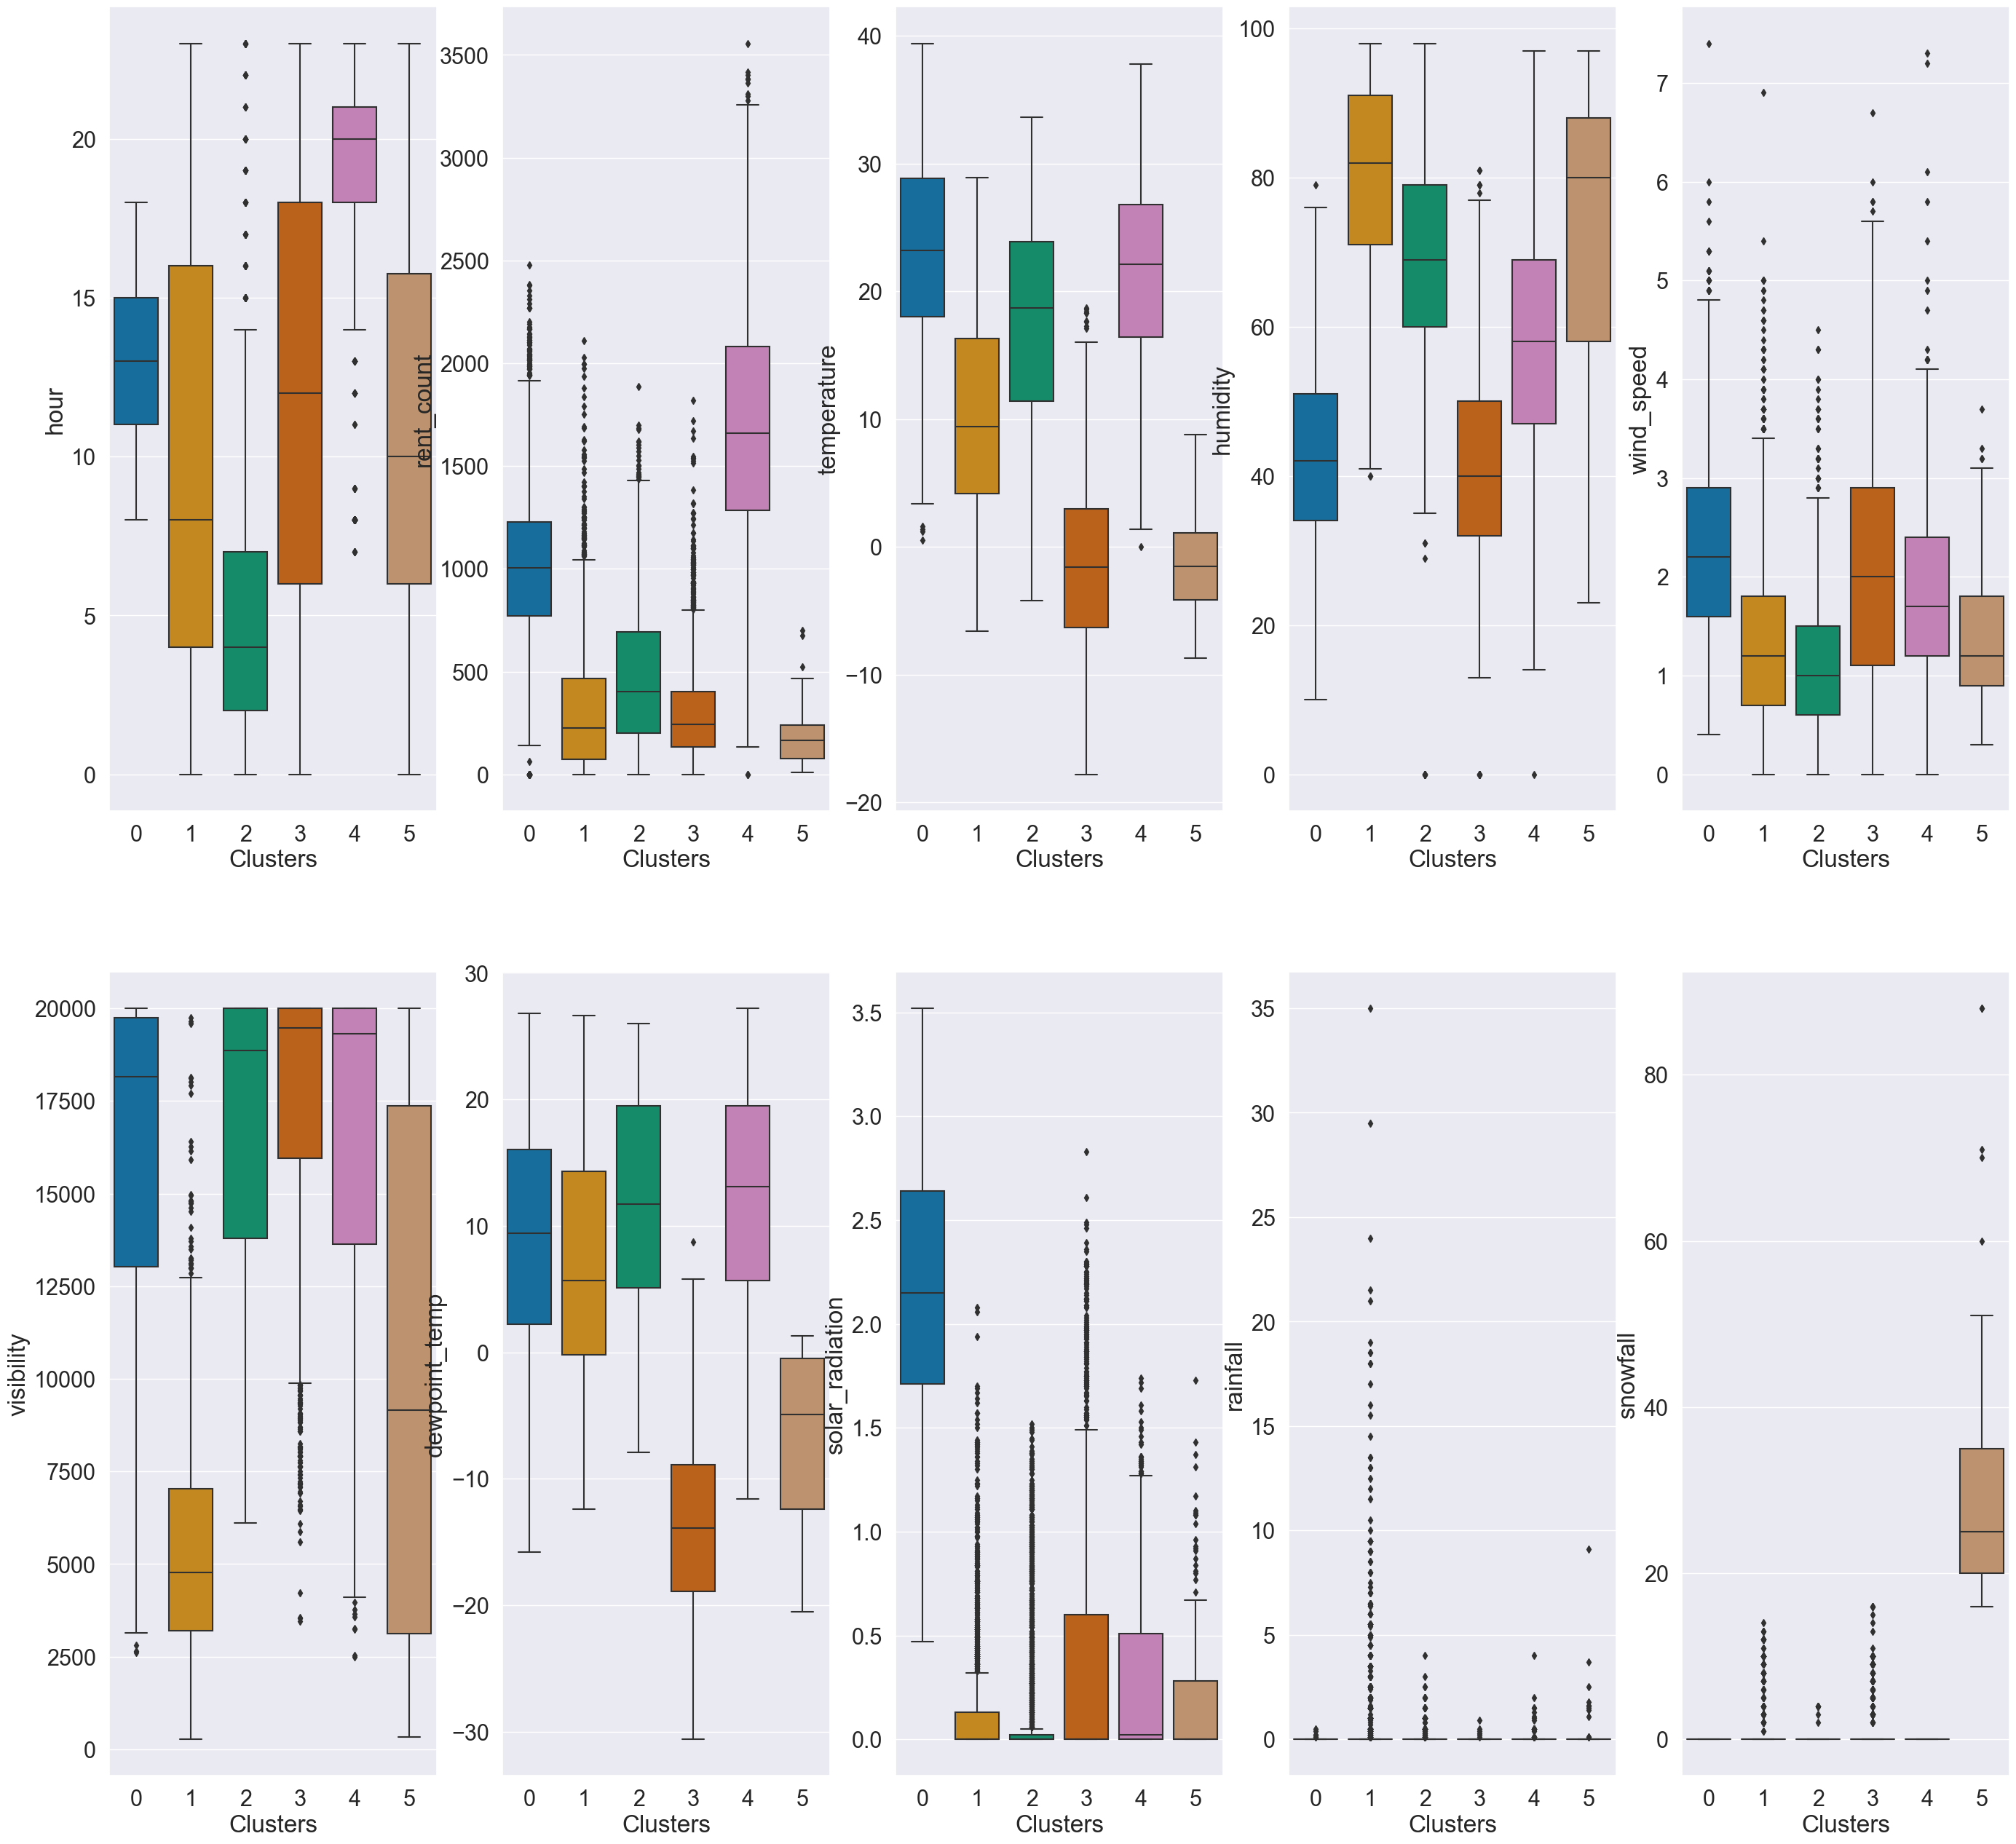

In [65]:
plot_boxplots(model6)
plt.show()

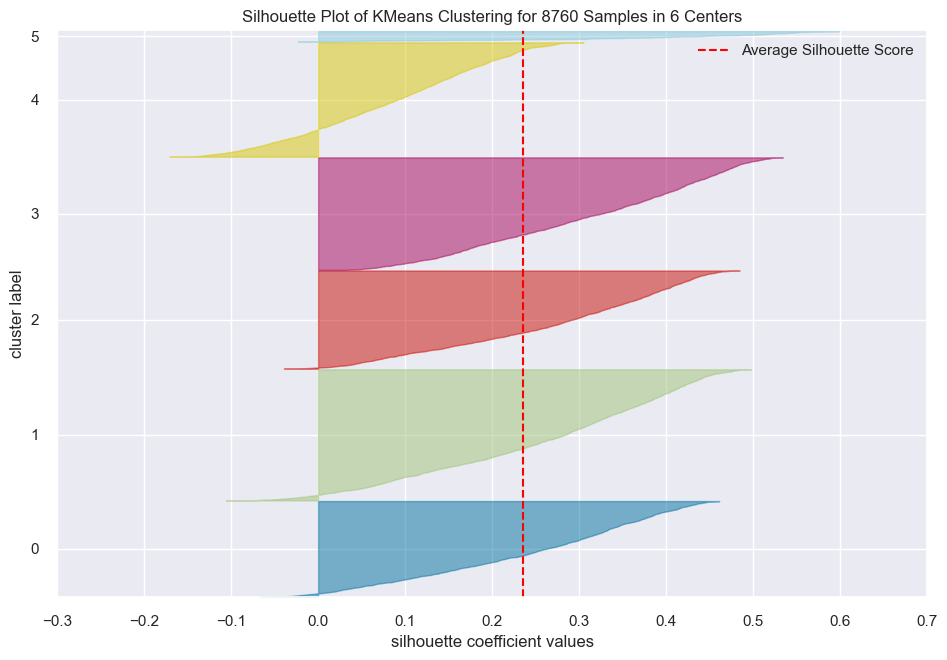

For n_clusters = 6 The average silhouette_score is: 0.23510339433306382 


In [66]:
plot_silhouettes(df_kmean,6)
plt.show()

## Summary
#### Silhouette Coefficient: a higher Silhouette Coefficient score relates to a model with better defined clusters.       
#### Calinski Harabasz Score: also known as the Variance Ratio Criterion, is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score , the better the performances.

In [105]:
kmeans3 = KMeans(init = 'random', n_clusters = 3, random_state=42)
kmeans3.fit(scaled_features)
print('For 3 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups3)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups3, metric = "euclidean")}')

For 3 clusters:
CH score: 2162.5346475800516
Silhouette score: 0.22923396348047517


In [102]:
kmeans4 = KMeans(init = 'random', n_clusters = 4, random_state=42)
kmeans4.fit(scaled_features)
print('For 4 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups4)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups4, metric = "euclidean")}')

For 4 clusters:
CH score: 1920.84756747687
Silhouette score: 0.2363176216991027


In [103]:
kmeans5 = KMeans(init = 'random', n_clusters = 5, random_state=42)
kmeans5.fit(scaled_features)
print('For 5 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups5, metric = "euclidean")}')

For 5 clusters:
CH score: 1918.7922788669516
Silhouette score: 0.2416300005731074


In [104]:
kmeans6 = KMeans(init = 'random', n_clusters = 6, random_state=42)
kmeans6.fit(scaled_features)
print('For 6 clusters:')
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups6)}')
print(f'Silhouette score: {silhouette_score(scaled_features, clustergroups6, metric = "euclidean")}')

For 6 clusters:
CH score: 1878.1339574979133
Silhouette score: 0.23512134529116252


In [94]:
clustergroups3 = kmeans3.labels_
Clustercenters3 = pd.DataFrame(scaler.inverse_transform(kmeans3.cluster_centers_), columns = df_kmean.columns)
Clustercenters3

,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,7.598846,393.507937,13.411948,76.223377,1.200837,10510.473304,9.055815,0.115169,0.372496,1.180664e+00
1,15.541667,1356.744000,22.844233,50.174000,2.056533,16464.976667,11.254367,1.238417,0.003233,7.105427e-15
2,12.106754,321.820044,-0.937124,41.579956,2.082658,17451.947712,-12.834379,0.379564,0.000915,1.082789e+00


### DBSCAN + Gower Distance
for clustering on categorical variables 
https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad

In [114]:
# !pip install gower
import gower
from sklearn.cluster import DBSCAN

In [115]:
distance_matrix = gower.gower_matrix(df_kmean)
distance_matrix.shape

(8760, 8760)

In [120]:
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,0.000000,0.026218,0.030802,0.039554,0.027841,0.039530,0.048078,0.061603,0.076944,0.099705,...,0.169219,0.173428,0.163276,0.150014,0.165138,0.146574,0.131007,0.159974,0.162233,0.158949
1,0.026218,0.000000,0.009990,0.016039,0.041502,0.034272,0.037414,0.040900,0.063687,0.078340,...,0.186741,0.190950,0.161879,0.164834,0.174552,0.164096,0.148529,0.137618,0.145282,0.150106
2,0.030802,0.009990,0.000000,0.009098,0.033553,0.026323,0.029915,0.037397,0.057482,0.077540,...,0.182630,0.186839,0.157768,0.160723,0.170441,0.159985,0.144417,0.136871,0.139130,0.143954
3,0.039554,0.016039,0.009098,0.000000,0.030244,0.022315,0.029618,0.034398,0.057185,0.074541,...,0.182686,0.186895,0.157825,0.160779,0.170497,0.160042,0.144474,0.134225,0.137146,0.141970
4,0.027841,0.041502,0.033553,0.030244,0.000000,0.017670,0.028732,0.048404,0.063745,0.084465,...,0.160237,0.161743,0.154294,0.141032,0.156156,0.134889,0.121362,0.153033,0.155292,0.152008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.146574,0.164096,0.159985,0.160042,0.134889,0.142626,0.138396,0.135722,0.115932,0.141324,...,0.113400,0.099177,0.076064,0.033026,0.038070,0.000000,0.025647,0.060808,0.056302,0.062437
8756,0.131007,0.148529,0.144417,0.144474,0.121362,0.127059,0.126910,0.120154,0.109701,0.139177,...,0.106753,0.101470,0.079098,0.050566,0.054225,0.025647,0.000000,0.038405,0.041399,0.046014
8757,0.159974,0.137618,0.136871,0.134225,0.153033,0.137107,0.131554,0.111946,0.112876,0.118955,...,0.142286,0.139267,0.092637,0.080321,0.078575,0.060808,0.038405,0.000000,0.022926,0.034636
8758,0.162233,0.145282,0.139130,0.137146,0.155292,0.139366,0.133813,0.116907,0.114123,0.130673,...,0.145280,0.142262,0.093300,0.074091,0.070175,0.056302,0.041399,0.022926,0.000000,0.017791


In [159]:
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=10, 
                        metric="precomputed", leaf_size=100)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
df_gower = df_kmean.copy(deep=True)
df_gower["cluster"] = dbscan_cluster.labels_

In [160]:
df_gower.cluster.value_counts(dropna=False)

0    8760
Name: cluster, dtype: int64